In [1]:
import os
import math
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc

from src.experiment import train_federated, create_model, train_central
from src.utils import parse_filename, normalize

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model

import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{libertine}'
mpl.rc('font', family='serif')

In [2]:
data_name = "10_500_50_10_0.5_0.1_0.02_0.6_0.2_local_d.npy"
out_name = "10_500_50_10_0.5_0.1_0.02_0.6_0.2_local_o.npy"
data = np.load(os.path.join(os.getcwd(), "data", "synth", data_name))
is_outlier = np.load(os.path.join(os.getcwd(), "data", "synth", out_name))
params = parse_filename(data_name)

print(data.shape)

(10, 500, 10)


In [3]:
num_devices = params["num_devices"]
dims = params["dims"]
steps = params["steps"]
subspace_frac = ["subspace_frac"]
frac_outlying_devices = params["frac_outlying_devices"]
frac_outlying_data = params["frac_outlying_data"]
compression_factor = 0.5
num_data = data.shape[1]

T_start = 0
T = steps-T_start
n = int(num_data/steps)

In [4]:
print(data.shape)
static_data = np.reshape(data, newshape=(data.shape[0]*data.shape[1], data.shape[2]))

# TRAIN FEDERATED
frac_available = 1
client_ids = range(num_devices)

encoding_dim = int(dims*0.8)
input = Input(shape=(dims,))
encoded = Dense(encoding_dim, activation='relu')(input)
decoded = Dense(dims, activation='sigmoid')(encoded)
model = Model(inputs=input, outputs=decoded)

encoder = Model(inputs=input, outputs=encoded)

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = model.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

model.compile(optimizer='adadelta', loss='binary_crossentropy')

model.fit(static_data, static_data,
                epochs=30,
                batch_size=32,
                shuffle=True,
                verbose=1)

(10, 500, 10)
Train on 5000 samples
Epoch 1/30
5000/5000 [==============================] - 1s 214us/sample - loss: 0.8569
Epoch 2/30
5000/5000 [==============================] - 0s 58us/sample - loss: 0.8559
Epoch 3/30
5000/5000 [==============================] - 0s 48us/sample - loss: 0.8549
Epoch 4/30
5000/5000 [==============================] - 0s 45us/sample - loss: 0.8538
Epoch 5/30
5000/5000 [==============================] - 0s 44us/sample - loss: 0.8526
Epoch 6/30
5000/5000 [==============================] - 0s 43us/sample - loss: 0.8513
Epoch 7/30
5000/5000 [==============================] - 0s 54us/sample - loss: 0.8500
Epoch 8/30
5000/5000 [==============================] - 0s 57us/sample - loss: 0.8486
Epoch 9/30
5000/5000 [==============================] - 0s 55us/sample - loss: 0.8473
Epoch 10/30
5000/5000 [==============================] - 0s 46us/sample - loss: 0.8458
Epoch 11/30
5000/5000 [==============================] - 0s 44us/sample - loss: 0.8443
Epoch 12/30
500

In [5]:
predictions = model.predict(static_data)
predictions = np.reshape(predictions, newshape=data.shape)

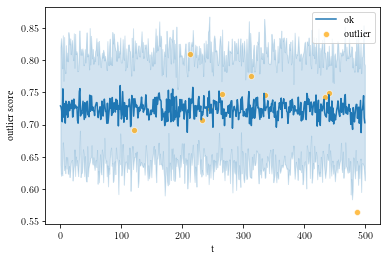

In [9]:
diff = data[:, T_start*n:] - predictions
dist = np.linalg.norm(diff, axis=-1)
dist = dist/np.max(dist)
labels = is_outlier[:, T_start*n:].any(axis=-1)

# ugly but working
io = []
nio = []
for i, row in enumerate(dist):
    for j, val in enumerate(row):
        if labels[i][j]:
            nio.append([j, val])
        else:
            io.append([j, val])
io = pd.DataFrame(io)
nio = pd.DataFrame(nio)

sns.lineplot(io[0], io[1], label="ok", ci="sd", err_style="band")
sns.scatterplot(nio[0], nio[1], label="outlier", color="orange", alpha=0.7)
plt.xlabel("t")
plt.ylabel("outlier score")
plt.legend()
plt.show()

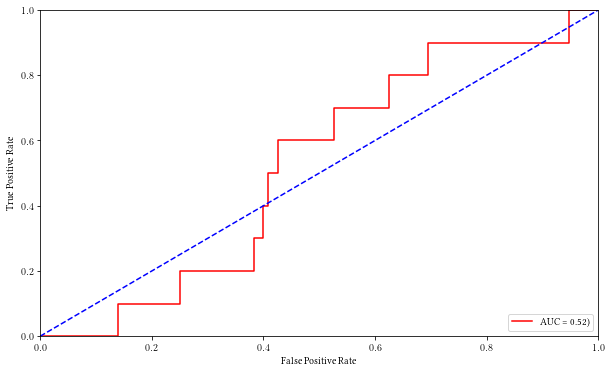

In [7]:
fpr, tpr, thresholds = roc_curve(labels.flatten(), dist.flatten())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='red', label='AUC = %0.2f)' % roc_auc)
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Autoencoder 100-80-100 ReLU/Sigmoid synth\_multidim\_100\_000')
plt.legend(loc="lower right")
plt.show()

In [8]:
n = 10  # how many digits we will display
fig = plt.figure(figsize=(20, 5))
for i in range(n):
    m = int(math.sqrt(dims))
    test = data[i][-1].reshape(m, m)
    out = is_outlier[i][-1].reshape(m, m)
    prediction = predictions[i][0].reshape(m, m)

    # display original
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(test, cmap="Blues")
    ax.get_xaxis().set_visible(False)
    ax.set_title("Device {}".format(i))
    if i == 0:
        ax.set_ylabel("original")
    else:
        ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(prediction, cmap="Blues")
    ax.get_xaxis().set_visible(False)
    if i == 0:
        ax.set_ylabel("generated")
    else:
        ax.get_yaxis().set_visible(False)

        # display reconstruction
    diff = np.abs(test - prediction)
    ax = plt.subplot(4, n, i + 1 + 2 * n)
    plt.imshow(diff, cmap="Blues")
    ax.get_xaxis().set_visible(False)
    if i == 0:
        ax.set_ylabel("difference")
    else:
        ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(4, n, i + 1 + 3 * n)
    plt.imshow(out, cmap="Blues")
    ax.get_xaxis().set_visible(False)
    if i == 0:
        ax.set_ylabel("outliers")
    else:
        ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()


ValueError: cannot reshape array of size 10 into shape (3,3)

<Figure size 1440x360 with 0 Axes>